# **Imports**

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split

from IPython.display import Audio
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Conv2D ,MaxPooling1D , MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# **Loading Dataset**

In [2]:
# Paths for data.
Crema = "/kaggle/input/speech-emotion-recognition-en/Crema/"

In [3]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,disgust,/kaggle/input/speech-emotion-recognition-en/Cr...
1,happy,/kaggle/input/speech-emotion-recognition-en/Cr...
2,happy,/kaggle/input/speech-emotion-recognition-en/Cr...
3,disgust,/kaggle/input/speech-emotion-recognition-en/Cr...
4,disgust,/kaggle/input/speech-emotion-recognition-en/Cr...


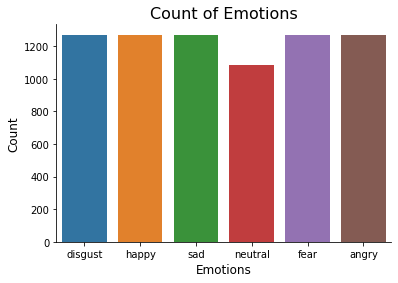

In [4]:
plt.title('Count of Emotions', size=16)
sns.countplot(Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# **Visualization**

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

## **Audio and Plottings**

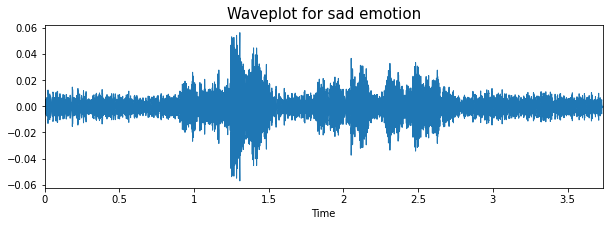

(82403,)


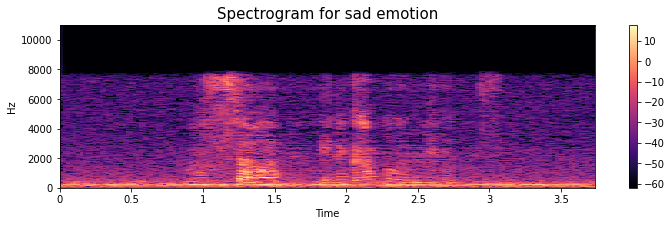

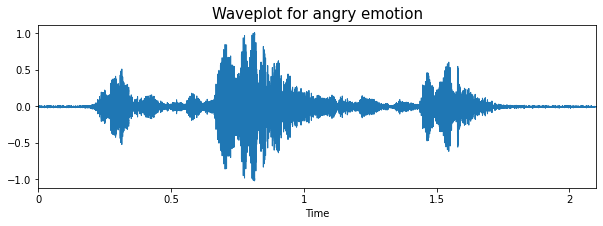

(46352,)


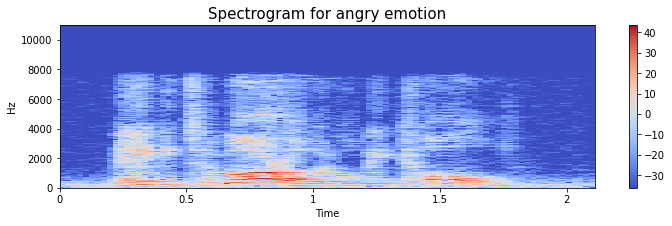

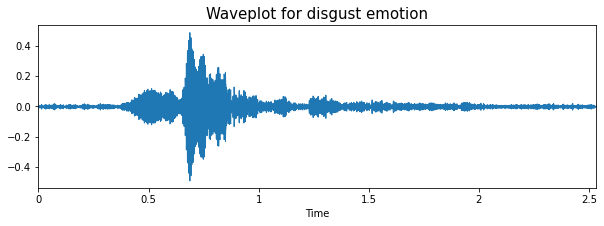

(55917,)


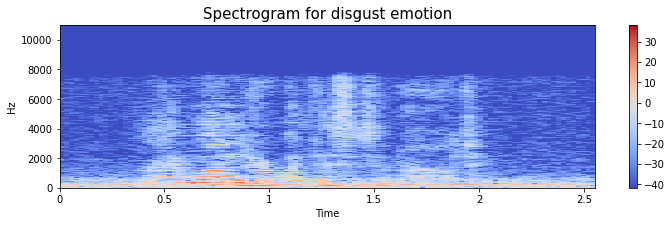

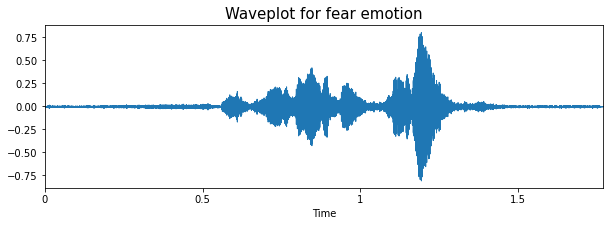

(38995,)


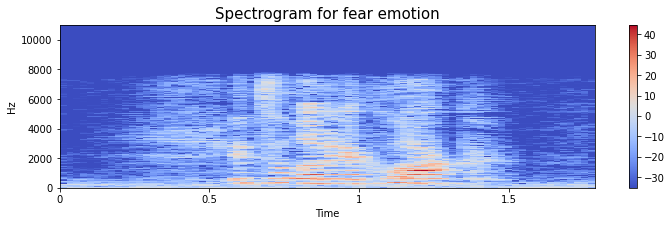

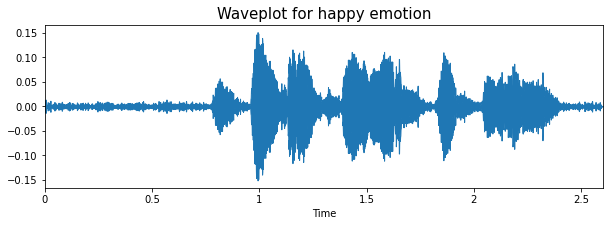

(57388,)


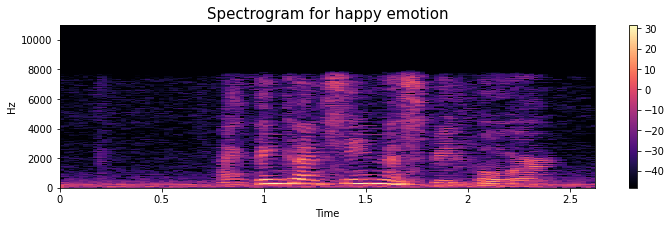

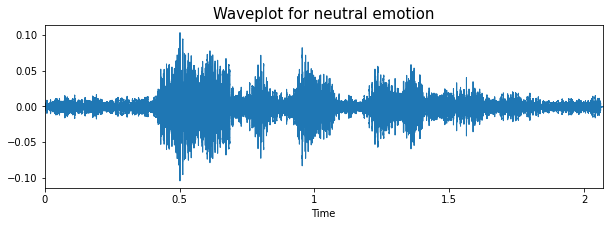

(45616,)


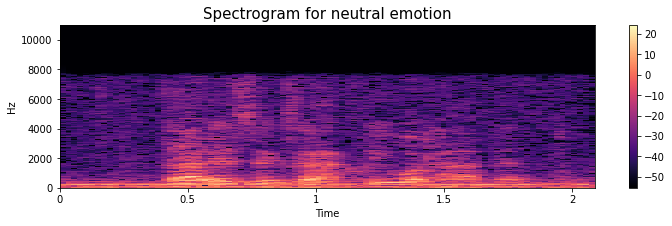

In [6]:
emotions = ['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral']
for emotion in emotions:
    path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(path))
    print(data.shape)

# **Feature Space**

In [7]:
def extract_features_time(data, sample_rate):
    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    
    # Energy
    frame_length=2048
    hop_length=512
    en = np.mean([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    
    return np.append(zcr,en)
    
def extract_features_spect(data, sample_rate):
    # MelSpectogram
    return librosa.feature.melspectrogram(y=data, sr=sample_rate)

### **Loading audio files**

In [8]:
data = []
sample_rates = []
for path in Crema_df.Path:
    aud, sam = librosa.load(path)
    data.append(aud)
    sample_rates.append(sam)

In [9]:
for i in range(7442):
    data[i] = data[i][:56072]

In [10]:
for i in range(7442):
    while len(data[i]) < 56072:
        data[i] = np.append(data[i], 0)


In [11]:
x_time, y = [], []
x_spect = []
for audio_file, sample_rate, emotion in zip(data, sample_rates, Crema_df.Emotions):
    x_time.append(extract_features_time(audio_file, sample_rate))
    x_spect.append(extract_features_spect(audio_file, sample_rate))
    y.append(emotion)

In [12]:
x_time = np.array(x_time)
x_spect = np.array(x_spect)
y = np.array(y)
x_time.shape, x_spect.shape, y.shape, Crema_df.Path.shape

((7442, 2), (7442, 128, 110), (7442,), (7442,))

In [13]:
Features_time = pd.DataFrame(x_time)
Features_time['labels'] = y

In [14]:
x_time = Features_time.iloc[: ,:-1].values

In [15]:
encoder = OneHotEncoder()
y_time = encoder.fit_transform(np.array(Features_time['labels'].values).reshape(-1,1)).toarray()

# **Splitting**

In [51]:
x_train_time, x_test_time, y_train_time, y_test_time = train_test_split(x_time, y_time,
                                                                        test_size=0.3, random_state=1)
x_train_time, x_val_time, y_train_time, y_val_time = train_test_split(x_train_time, y_train_time,
                                                                      test_size=0.05, random_state=1)

x_train_spect, x_test_spect, y_train_spect, y_test_spect = train_test_split(x_spect, y_time,
                                                                            test_size=0.3, random_state=1)
x_train_spect, x_val_spect, y_train_spect, y_val_spect = train_test_split(x_train_spect, y_train_spect,
                                                                          test_size=0.05, random_state=1)

In [52]:
print((x_train_time.shape, y_train_time.shape, x_test_time.shape, y_test_time.shape, x_val_time.shape, y_val_time.shape))

print((x_train_spect.shape, y_train_spect.shape, x_test_spect.shape, y_test_spect.shape, x_val_spect.shape, y_val_spect.shape))

((4948, 2), (4948, 6), (2233, 2), (2233, 6), (261, 2), (261, 6))
((4948, 128, 110), (4948, 6), (2233, 128, 110), (2233, 6), (261, 128, 110), (261, 6))


In [53]:
# making our data compatible to model.
x_train_time = np.expand_dims(x_train_time, axis=2)
x_val_time = np.expand_dims(x_val_time, axis=2)
x_test_time = np.expand_dims(x_test_time, axis=2)
x_train_time.shape, x_val_time.shape, x_test_time.shape

((4948, 2, 1), (261, 2, 1), (2233, 2, 1))

# **1D CNN Model (Time Domain)**

In [54]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same',
                 activation='relu', input_shape=(x_train_time.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 2, 256)            1536      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1, 256)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 256)            327936    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1, 256)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1, 128)            163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 128)           

In [55]:
history=model.fit(x_train_time, y_train_time, batch_size=32, epochs=50, validation_data=(x_val_time, y_val_time))

Epoch 1/50
155/155 [==============================] - 1s 5ms/step - loss: 1.7807 - accuracy: 0.2066 - val_loss: 1.7313 - val_accuracy: 0.3142
Epoch 2/50
155/155 [==============================] - 1s 4ms/step - loss: 1.7220 - accuracy: 0.2953 - val_loss: 1.6443 - val_accuracy: 0.3410
Epoch 3/50
155/155 [==============================] - 1s 4ms/step - loss: 1.6532 - accuracy: 0.3158 - val_loss: 1.5864 - val_accuracy: 0.3410
Epoch 4/50
155/155 [==============================] - 1s 4ms/step - loss: 1.6049 - accuracy: 0.3275 - val_loss: 1.5717 - val_accuracy: 0.3487
Epoch 5/50
155/155 [==============================] - 1s 4ms/step - loss: 1.5987 - accuracy: 0.3368 - val_loss: 1.5458 - val_accuracy: 0.3602
Epoch 6/50
155/155 [==============================] - 1s 4ms/step - loss: 1.5758 - accuracy: 0.3475 - val_loss: 1.5457 - val_accuracy: 0.3716
Epoch 7/50
155/155 [==============================] - 1s 4ms/step - loss: 1.5674 - accuracy: 0.3682 - val_loss: 1.5325 - val_accuracy: 0.3640
Epoch 

# **2D CNN Model**

In [56]:
x_train_spect = np.expand_dims(x_train_spect, axis=3)
x_val_spect = np.expand_dims(x_val_spect, axis=3)
x_test_spect = np.expand_dims(x_test_spect, axis=3)
x_train_spect.shape, x_val_spect.shape, x_test_spect.shape

((4948, 128, 110, 1), (261, 128, 110, 1), (2233, 128, 110, 1))

In [57]:
model_spect = Sequential()
model_spect.add(Conv2D(32, kernel_size =(5, 5), strides =(1, 1),
                 activation ='relu', input_shape=(128, 110, 1)))
model_spect.add(MaxPooling2D(pool_size =(2, 2), strides =(2, 2)))
model_spect.add(Conv2D(64, (5, 5), activation ='relu'))
model_spect.add(MaxPooling2D(pool_size =(2, 2)))
model_spect.add(Flatten())
model_spect.add(Dense(1000, activation ='relu'))
model_spect.add(Dense(6, activation ='softmax'))

model_spect.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    metrics=['accuracy'])

model_spect.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 106, 32)      832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 53, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 58, 49, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 24, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 44544)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              44545000  
_________________________________________________________________
dense_9 (Dense)              (None, 6)                

In [58]:
history_spect = model_spect.fit(x_train_spect, y_train_spect,
                                batch_size=32, epochs=25, validation_data=(x_val_spect, y_val_spect))

Epoch 1/25
155/155 [==============================] - 3s 15ms/step - loss: 5.0878 - accuracy: 0.2440 - val_loss: 1.5863 - val_accuracy: 0.3793
Epoch 2/25
155/155 [==============================] - 2s 14ms/step - loss: 1.4353 - accuracy: 0.4175 - val_loss: 1.5411 - val_accuracy: 0.4176
Epoch 3/25
155/155 [==============================] - 2s 14ms/step - loss: 1.2222 - accuracy: 0.5396 - val_loss: 1.5539 - val_accuracy: 0.4330
Epoch 4/25
155/155 [==============================] - 2s 14ms/step - loss: 1.1101 - accuracy: 0.5756 - val_loss: 1.9310 - val_accuracy: 0.3985
Epoch 5/25
155/155 [==============================] - 2s 14ms/step - loss: 1.0122 - accuracy: 0.6256 - val_loss: 1.9152 - val_accuracy: 0.4138
Epoch 6/25
155/155 [==============================] - 2s 14ms/step - loss: 0.9604 - accuracy: 0.6529 - val_loss: 1.8917 - val_accuracy: 0.4215
Epoch 7/25
155/155 [==============================] - 2s 14ms/step - loss: 0.8890 - accuracy: 0.7009 - val_loss: 1.9182 - val_accuracy: 0.4215

# **Evaluation**

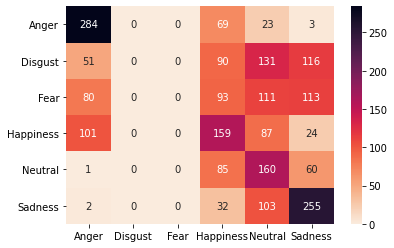

In [59]:
y_pred_time = model.predict(x_test_time)
matrix_time = confusion_matrix(y_test_time.argmax(axis=1), y_pred_time.argmax(axis=1))
ax = sns.heatmap(matrix_time, annot=True, fmt="d", cmap = 'rocket_r',
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

In [72]:
print(classification_report(y_test_time.argmax(axis=1), y_pred_time.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.55      0.75      0.63       379
           1       0.00      0.00      0.00       388
           2       0.00      0.00      0.00       397
           3       0.30      0.43      0.35       371
           4       0.26      0.52      0.35       306
           5       0.45      0.65      0.53       392

    accuracy                           0.38      2233
   macro avg       0.26      0.39      0.31      2233
weighted avg       0.26      0.38      0.31      2233



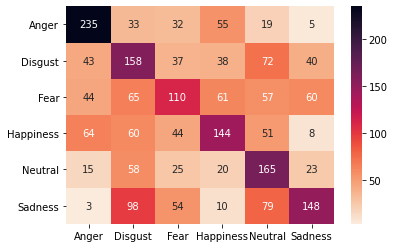

In [60]:
y_pred_spect = model_spect.predict(x_test_spect)
matrix_spect = confusion_matrix(y_test_spect.argmax(axis=1), y_pred_spect.argmax(axis=1))
ax = sns.heatmap(matrix_spect, annot=True, fmt="d", cmap = 'rocket_r',
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

In [73]:
print(classification_report(y_test_spect.argmax(axis=1), y_pred_spect.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.58      0.62      0.60       379
           1       0.33      0.41      0.37       388
           2       0.36      0.28      0.31       397
           3       0.44      0.39      0.41       371
           4       0.37      0.54      0.44       306
           5       0.52      0.38      0.44       392

    accuracy                           0.43      2233
   macro avg       0.44      0.43      0.43      2233
weighted avg       0.44      0.43      0.43      2233

